In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models  

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm, trange
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import confusion_matrix, accuracy_score  
import seaborn as sns


c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class Config:
    data_dir = "D:\\Leko\\medical_model\\task1\\dataset\\images"
    label_csv = "D:\\Leko\\medical_model\\task1\\dataset\\labels.csv"
    img_size = 224
    batch_size = 32
    epochs = 30
    lr = 5e-5  # ✅ ResNet34 推荐使用略高的学习率（如 5e-4 或 1e-4）
    num_workers = 0  # ✅ 增加 num_workers 提升加载速度
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_name = "efficientnet_b0"  # ✅ 替换为 ResNet34
    save_dir = "./output"
    seed = 42

torch.manual_seed(Config.seed)
os.makedirs(Config.save_dir, exist_ok=True)

In [3]:
class TumorDataset(Dataset):
    def __init__(self, df, img_dir, train=True):
        self.df      = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.train   = train
        
        if self.train:
            self.transform = get_transforms(train=True)
        else:
            self.transform = get_transforms(train=False)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row      = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        # 1) 读图并转成 numpy
        image = np.array(Image.open(img_path).convert('RGB'))
        # 2) 统一 transform
        image = self.transform(image=image)['image']  # 已经是 Tensor, C×H×W
        # 3) 取标签
        label = int(row['label'])
        return image, label


In [4]:
import torch
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader

def rand_bbox(size, lam):
    """
    CutMix 随机生成一个矩形框。
    size: tuple (W, H)
    lam: 从 Beta 分布中采样的 λ
    返回 (x0, y0, x1, y1)
    """
    W, H = size
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # 随机中心
    cx = random.randint(0, W)
    cy = random.randint(0, H)

    x0 = np.clip(cx - cut_w // 2, 0, W)
    y0 = np.clip(cy - cut_h // 2, 0, H)
    x1 = np.clip(cx + cut_w // 2, 0, W)
    y1 = np.clip(cy + cut_h // 2, 0, H)

    return x0, y0, x1, y1

class MixUpCollator:
    def __init__(self, alpha=0.4, prob=0.5):
        """
        alpha: MixUp Beta 分布参数
        prob: 每个 batch 应用 MixUp 的概率
        """
        self.alpha = alpha
        self.prob  = prob

    def __call__(self, batch):
        # batch: list of (image_tensor, label)
        images, labels = zip(*batch)
        images = torch.stack(images)                          # [B, C, H, W]
        labels = torch.tensor(labels, dtype=torch.float32).view(-1,1)  # [B, 1]

        if np.random.rand() > self.prob:
            return images, labels

        lam = np.random.beta(self.alpha, self.alpha)
        idx = torch.randperm(images.size(0))
        mixed_images = lam * images + (1. - lam) * images[idx]
        mixed_labels = lam * labels + (1. - lam) * labels[idx]
        return mixed_images, mixed_labels

class CutMixCollator:
    def __init__(self, beta=1.0, prob=0.5):
        """
        beta: CutMix Beta 分布参数
        prob: 每个 batch 应用 CutMix 的概率
        """
        self.beta = beta
        self.prob = prob

    def __call__(self, batch):
        images, labels = zip(*batch)
        images = torch.stack(images)                          
        labels = torch.tensor(labels, dtype=torch.float32).view(-1,1)  

        if np.random.rand() > self.prob:
            return images, labels

        lam = np.random.beta(self.beta, self.beta)
        idx = torch.randperm(images.size(0))

        # 随机裁框
        _, C, H, W = images.shape
        x0, y0, x1, y1 = rand_bbox((W, H), lam)

        images_cut = images.clone()
        # 将第 i 张图的 (y0:y1, x0:x1) 区域替换为第 idx[i] 张图同区域
        images_cut[:, :, y0:y1, x0:x1] = images[idx, :, y0:y1, x0:x1]

        # 重新计算 λ：去掉的区域比例
        area = (x1 - x0) * (y1 - y0)
        lam_adj = 1. - area / (W * H)

        mixed_labels = lam_adj * labels + (1. - lam_adj) * labels[idx]
        return images_cut, mixed_labels


In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_transforms(train=True):
    if train:
        return A.Compose([
            # 用 size 参数取代 height & width
            A.RandomResizedCrop(
                size=(Config.img_size, Config.img_size),
                scale=(0.8, 1.0),
                ratio=(0.9, 1.1),
                p=1.0
            ),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.ColorJitter(
                brightness=0.2, contrast=0.2,
                saturation=0.2, hue=0.1, p=0.5
            ),
            A.CoarseDropout(
                max_holes=8, max_height=16, max_width=16,
                min_holes=1, min_height=8, min_width=8, p=0.3
            ),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
            # 再保证输出尺寸
            A.Resize(
                height=Config.img_size,
                width=Config.img_size
            ),
            A.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)
            ),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(
                height=Config.img_size,
                width=Config.img_size
            ),
            A.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)
            ),
            ToTensorV2()
        ])



In [6]:
class TumorClassifier(nn.Module):
    def __init__(self, dropout_p=0.7):
        super().__init__()
        # 1) 加载预训练 EfficientNet-B0，去掉原来的 fc
        backbone = models.efficientnet_b0(pretrained=True)
        in_features = backbone.classifier[1].in_features  # EfficientNet-B0 classifier 是 Sequential(Dense, Linear)
        backbone.classifier = nn.Identity()

        self.backbone = backbone
        # 2) 加入 Dropout，再接分类 Linear
        self.dropout    = nn.Dropout(p=dropout_p)
        self.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        # backbone 输出 [B, in_features]
        features = self.backbone(x)
        # dropout 再接分类头
        features = self.dropout(features)
        out = self.classifier(features)
        return out

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    二分类 Focal Loss.
    logits: 网络原始输出，shape [B,1] 或 [B]
    targets: 0/1 标签，shape [B,1] 或 [B]
    """
    def __init__(self, gamma=2.0, alpha=0.25, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, targets):
        # flatten
        if logits.dim()>1:
            logits = logits.view(-1)
        targets = targets.view(-1).float()
        # 1) 先算 BCE
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        probas  = torch.sigmoid(logits)
        # 2) p_t
        p_t = probas * targets + (1 - probas) * (1 - targets)
        # 3) α 平衡因子
        alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        # 4) (1−p_t)^γ
        modulating_factor = (1 - p_t).pow(self.gamma)
        loss = alpha_factor * modulating_factor * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [8]:
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    total_loss = 0
    for images, labels in tqdm(loader):
        images = images.to(Config.device)

        # —— 修改这里：统一把 labels 变成 [B,1] —— 
        labels = labels.to(Config.device).float()
        if labels.dim() == 1:
            labels = labels.unsqueeze(1)  # 只在 [B] -> [B,1] 时加这一维

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)        # [B,1]
            loss    = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)


In [9]:
def evaluate(model, loader, criterion):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.inference_mode():
        for images, labels in loader:
            images = images.to(Config.device)
            labels = labels.to(Config.device).float()
            if labels.dim() == 1:
                labels = labels.unsqueeze(1)

            logits = model(images)
            loss   = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), np.array(all_preds).ravel(), np.array(all_labels).ravel()


In [10]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

In [11]:
from sklearn.model_selection import train_test_split

# 读取 CSV 标签
full_df = pd.read_csv(Config.label_csv)

# 三分法划分 train / val / test
train_df, tmp_df = train_test_split(
    full_df,
    test_size=0.3,
    stratify=full_df['label'],
    random_state=Config.seed
)
val_df, test_df = train_test_split(
    tmp_df,
    test_size=0.5,
    stratify=tmp_df['label'],
    random_state=Config.seed
)

print(f"训练集类别分布：\n{train_df['label'].value_counts()}")
print(f"验证集类别分布：\n{val_df['label'].value_counts()}")
print(f"测试集类别分布：\n{test_df['label'].value_counts()}")

训练集类别分布：
label
0    7552
1    1816
Name: count, dtype: int64
验证集类别分布：
label
0    1618
1     389
Name: count, dtype: int64
测试集类别分布：
label
0    1619
1     389
Name: count, dtype: int64


In [12]:
use_mix_mode = "mixup"  # 可选: "none", "mixup", "cutmix"
if use_mix_mode.lower() == "cutmix":
    collate_fn = CutMixCollator(beta=1.0, prob=0.5)
    shuffle_train = False
elif use_mix_mode.lower() == "mixup":
    collate_fn = MixUpCollator(alpha=0.4, prob=0.5)
    shuffle_train = False
else:
    collate_fn = None
    shuffle_train = True

print(f"Mix mode={use_mix_mode}, shuffle_train={shuffle_train}")

# 构建 Dataset
train_dataset = TumorDataset(train_df, Config.data_dir, train=True)
val_dataset   = TumorDataset(val_df,   Config.data_dir, train=False)
test_dataset  = TumorDataset(test_df,  Config.data_dir, train=False)

# 构建 DataLoader
from torch.utils.data import WeightedRandomSampler

# 在构建 train_loader 之前，加一段计算每个样本权重的代码：
class_counts = train_df['label'].value_counts().to_dict()  
# e.g. {0: 9000, 1: 1000}
weights = train_df['label'].map(lambda x: 1.0 / class_counts[x]).values
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# 然后把 train_loader 改成：
train_loader = DataLoader(
    train_dataset,
    batch_size=Config.batch_size,
    shuffle=False,            # 用 sampler 时不要再 shuffle
    sampler=sampler,
    num_workers=Config.num_workers,
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.batch_size,
    shuffle=False,
    num_workers=Config.num_workers
)
test_loader = DataLoader(
    test_dataset,
    batch_size=Config.batch_size,
    shuffle=False,
    num_workers=Config.num_workers
)

# 初始化模型
print("🧠 初始化模型中...")
model = TumorClassifier(dropout_p=0.8).to(Config.device)
print("✅ 模型初始化完成")

optimizer = optim.Adam(
    model.parameters(),
    lr=Config.lr,
    weight_decay=5e-4
)
# 使用 Focal Loss，gamma 和 alpha 可调
criterion = FocalLoss(gamma=2.0, alpha=0.25, reduction='mean')

early_stopper = EarlyStopping(patience=5)
scaler = GradScaler()

history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_f1': []}
best_auc = 0
best_thresh = 0.5  # 会在训练中更新

# 显示训练集类别分布
train_labels = train_df['label']
print(f"📊 当前训练集图像分布：正常类 {(train_labels == 0).sum()}，肿瘤类 {(train_labels == 1).sum()}")

Mix mode=mixup, shuffle_train=False
🧠 初始化模型中...


C:\Users\15307\AppData\Local\Temp\ipykernel_7704\2718584782.py:20: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width' are not valid for transform CoarseDropout
  A.CoarseDropout(
C:\Users\15307\AppData\Local\Temp\ipykernel_7704\2718584782.py:24: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=Efficient

✅ 模型初始化完成
📊 当前训练集图像分布：正常类 7552，肿瘤类 1816


C:\Users\15307\AppData\Local\Temp\ipykernel_7704\255403969.py:66: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [13]:
# —— 训练循环：只用 Val AUC 早停，不在每轮中做阈值搜索 —— 

best_auc     = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_auc': []}

for epoch in range(Config.epochs):
    print(f"\n📘 Epoch {epoch+1}/{Config.epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    val_loss, preds, targets = evaluate(model, val_loader, criterion)
    val_auc = roc_auc_score(targets, preds)

    # 打印指标（仅用 AUC 评估）
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f}")

    # 记录历史
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)

    # 保存最优模型（按 AUC）
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), os.path.join(Config.save_dir, "best_model.pth"))
        print("✅ Best model saved.")

    # 早停检查（监控 AUC）
    early_stopper(val_auc)
    if early_stopper.early_stop:
        print("⏹️ Early stopping triggered.")
        break

# —— 训练结束后，再做一次整体阈值搜素 & 最终评估 —— 

# 加载最佳模型权重
model.load_state_dict(torch.load(os.path.join(Config.save_dir, "best_model.pth")))
model.eval()

# 在整个验证集上计算概率
_, preds, targets = evaluate(model, val_loader, criterion)
preds = preds.ravel()
targets = targets.ravel()

# 搜索最佳 F1 阈值
best_f1, best_thresh = 0.0, 0.5
for t in np.arange(0.1, 0.9, 0.01):
    f1 = f1_score(targets, (preds >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_thresh = f1, t

# 最终按最佳阈值计算指标
final_preds = (preds >= best_thresh).astype(int)
final_acc  = accuracy_score(targets, final_preds)
final_auc  = roc_auc_score(targets, preds)
tn, fp, fn, tp = confusion_matrix(targets, final_preds).ravel()
final_spec = tn/(tn+fp)
final_sens = tp/(tp+fn)

print("\n=== 最终验证集评估 ===")
print(f"Best F1 Threshold: {best_thresh:.2f}")
print(f"ACC:         {final_acc:.4f}")
print(f"F1-score:    {best_f1:.4f}")
print(f"AUC:         {final_auc:.4f}")
print(f"Specificity: {final_spec:.4f}")
print(f"Sensitivity: {final_sens:.4f}")



📘 Epoch 1/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [03:17<00:00,  1.48it/s]


Train Loss: 0.0763 | Val Loss: 0.0361 | Val AUC: 0.8981
✅ Best model saved.

📘 Epoch 2/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [02:23<00:00,  2.04it/s]


Train Loss: 0.0603 | Val Loss: 0.0324 | Val AUC: 0.9201
✅ Best model saved.

📘 Epoch 3/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [02:05<00:00,  2.33it/s]


Train Loss: 0.0547 | Val Loss: 0.0327 | Val AUC: 0.9322
✅ Best model saved.

📘 Epoch 4/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:55<00:00,  2.54it/s]


Train Loss: 0.0527 | Val Loss: 0.0256 | Val AUC: 0.9398
✅ Best model saved.

📘 Epoch 5/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:49<00:00,  2.67it/s]


Train Loss: 0.0476 | Val Loss: 0.0272 | Val AUC: 0.9432
✅ Best model saved.

📘 Epoch 6/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:46<00:00,  2.75it/s]


Train Loss: 0.0460 | Val Loss: 0.0270 | Val AUC: 0.9472
✅ Best model saved.

📘 Epoch 7/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:44<00:00,  2.82it/s]


Train Loss: 0.0450 | Val Loss: 0.0266 | Val AUC: 0.9502
✅ Best model saved.

📘 Epoch 8/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


Train Loss: 0.0445 | Val Loss: 0.0278 | Val AUC: 0.9494

📘 Epoch 9/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:46<00:00,  2.76it/s]


Train Loss: 0.0425 | Val Loss: 0.0278 | Val AUC: 0.9516
✅ Best model saved.

📘 Epoch 10/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:44<00:00,  2.80it/s]


Train Loss: 0.0411 | Val Loss: 0.0267 | Val AUC: 0.9492

📘 Epoch 11/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:45<00:00,  2.78it/s]


Train Loss: 0.0421 | Val Loss: 0.0234 | Val AUC: 0.9506

📘 Epoch 12/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:47<00:00,  2.73it/s]


Train Loss: 0.0384 | Val Loss: 0.0241 | Val AUC: 0.9561
✅ Best model saved.

📘 Epoch 13/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:43<00:00,  2.82it/s]


Train Loss: 0.0395 | Val Loss: 0.0272 | Val AUC: 0.9505

📘 Epoch 14/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:45<00:00,  2.79it/s]


Train Loss: 0.0387 | Val Loss: 0.0262 | Val AUC: 0.9546

📘 Epoch 15/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:43<00:00,  2.83it/s]


Train Loss: 0.0352 | Val Loss: 0.0263 | Val AUC: 0.9545

📘 Epoch 16/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:41<00:00,  2.88it/s]


Train Loss: 0.0362 | Val Loss: 0.0269 | Val AUC: 0.9546

📘 Epoch 17/30


  0%|          | 0/293 [00:00<?, ?it/s]C:\Users\15307\AppData\Local\Temp\ipykernel_7704\1923650141.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 293/293 [01:42<00:00,  2.87it/s]


Train Loss: 0.0351 | Val Loss: 0.0252 | Val AUC: 0.9544
⏹️ Early stopping triggered.

=== 最终验证集评估 ===
Best F1 Threshold: 0.46
ACC:         0.9243
F1-score:    0.8046
AUC:         0.9561
Specificity: 0.9530
Sensitivity: 0.8046


✅ 划分校验通过，train/val/test 三个集合互不重叠。


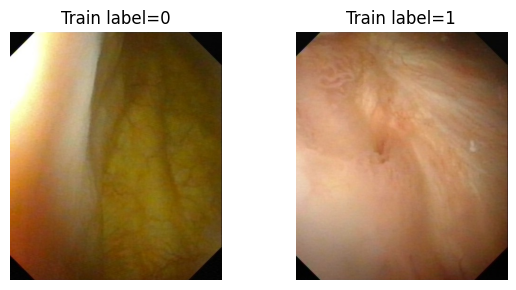

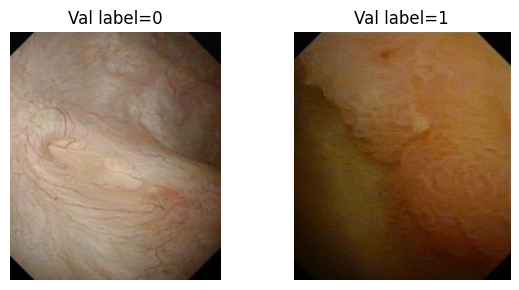

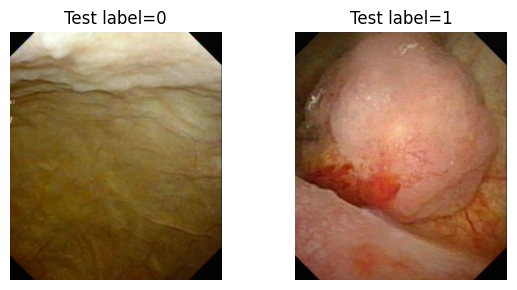

In [14]:
import random
# —— 在三分法划分后加入以下检查 —— 
train_files = set(train_df['filename'].tolist())
val_files   = set(val_df  ['filename'].tolist())
test_files  = set(test_df ['filename'].tolist())

# 检查两两交集是否为空
assert train_files.isdisjoint(val_files),  \
    f"数据泄露：train 与 val 有 {len(train_files & val_files)} 张图重复"
assert train_files.isdisjoint(test_files), \
    f"数据泄露：train 与 test 有 {len(train_files & test_files)} 张图重复"
assert val_files.isdisjoint(test_files),   \
    f"数据泄露：val   与 test 有 {len(val_files & test_files)} 张图重复"

print("✅ 划分校验通过，train/val/test 三个集合互不重叠。")

# 手动设置路径和参数
label_csv = r"D:\Leko\medical_model\task1\dataset\labels.csv"
img_dir   = r"D:\Leko\medical_model\task1\dataset\images"
seed = 42

# 1. 读取标签并去重
df = pd.read_csv(label_csv).drop_duplicates(subset=['filename'])

# 2. 三分法划分
train_df, tmp_df = train_test_split(
    df, test_size=0.3, stratify=df['label'], random_state=seed
)
val_df, test_df = train_test_split(
    tmp_df, test_size=0.5, stratify=tmp_df['label'], random_state=seed
)

# 3. 定义显示函数
def show_samples(df, name):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    for ax, label in zip(axes, [0, 1]):
        subset = df[df['label'] == label]
        fname = random.choice(subset['filename'].tolist())
        img = Image.open(os.path.join(img_dir, fname)).convert('RGB')
        ax.imshow(img)
        ax.set_title(f"{name} label={label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 4. 显示三个集合的样本
show_samples(train_df, "Train")
show_samples(val_df, "Val")
show_samples(test_df, "Test")



🧪 Test Loss: 0.0272 | Test AUC: 0.9523 | Test F1: 0.7835 | Test Acc: 0.9163
🧪 Test Sensitivity (Recall for tumor): 0.7815 | Test Specificity (Recall for normal): 0.9487


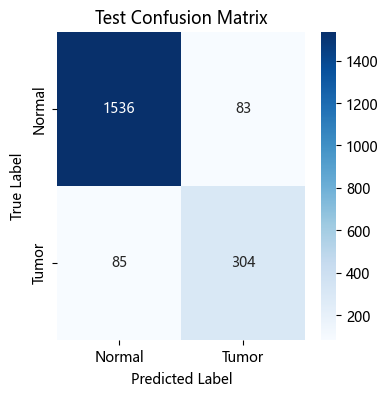

In [18]:
# 加载最佳模型
model.load_state_dict(torch.load(os.path.join(Config.save_dir, "best_model.pth")))
model.eval()

# 在测试集上评估
test_loss, test_preds, test_targets = evaluate(model, test_loader, criterion)
test_auc  = roc_auc_score(test_targets, test_preds)
test_f1   = f1_score(test_targets, (test_preds >= best_thresh).astype(int))
test_acc  = accuracy_score(test_targets, (test_preds >= best_thresh).astype(int))

# 计算混淆矩阵并提取指标
cm = confusion_matrix(test_targets, (test_preds >= best_thresh).astype(int))
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn + 1e-8)  # True Positive Rate
specificity = tn / (tn + fp + 1e-8)  # True Negative Rate

# 打印所有指标
print(f"🧪 Test Loss: {test_loss:.4f} | Test AUC: {test_auc:.4f} | "
      f"Test F1: {test_f1:.4f} | Test Acc: {test_acc:.4f}")
print(f"🧪 Test Sensitivity (Recall for tumor): {sensitivity:.4f} | "
      f"Test Specificity (Recall for normal): {specificity:.4f}")

# 绘制测试集混淆矩阵
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Tumor"],
            yticklabels=["Normal", "Tumor"])
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 保存测试集预测结果
test_df = test_df.copy()
test_df['pred_prob']  = test_preds
test_df['pred_label'] = (test_preds >= best_thresh).astype(int)
test_df.to_csv(os.path.join(Config.save_dir, "test_predictions.csv"), index=False)


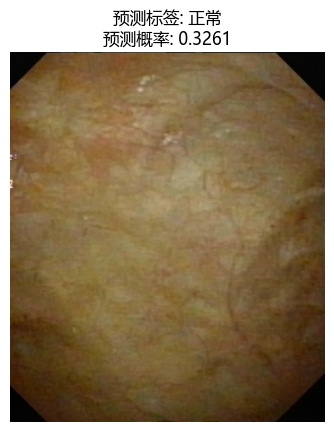

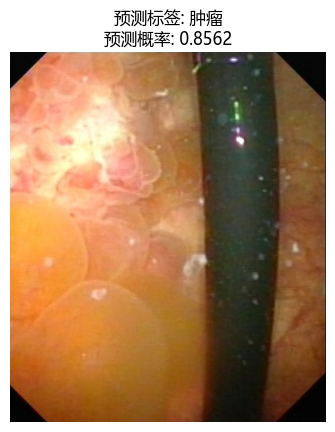

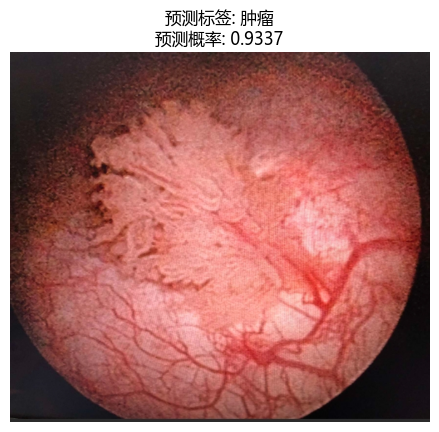

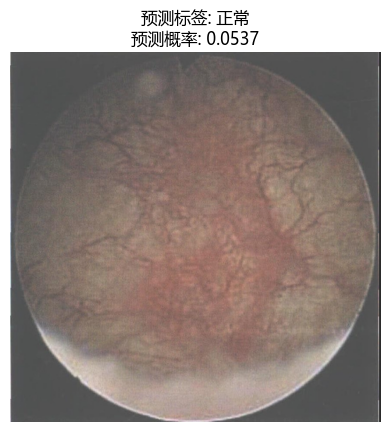

In [19]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import matplotlib

# ✅ 设置中文字体（以微软雅黑为例）
matplotlib.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# ✅ 加载模型结构（必须与你训练时的结构一致）
#model = TumorClassifier().to(Config.device)
model.load_state_dict(torch.load("D:\\Leko\\medical_model\\task1\\model\\Effic_cutmix\\output\\best_model.pth"))
model.eval()

# ✅ 加载你训练时的图像预处理（transform）
infer_transform = get_transforms(train=False)

# ✅ 推理函数
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    
    # Apply transform
    transformed = infer_transform(image=image_np)
    input_tensor = transformed['image'].unsqueeze(0).to(Config.device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output).item()
        label = 1 if prob >= 0.5 else 0

    # 可视化
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f"预测标签: {'肿瘤' if label==1 else '正常'}\n预测概率: {prob:.4f}")
    plt.show()

# ✅ 使用示例
predict_image("D:\\Leko\\test1.jpg")
predict_image("D:\\Leko\\test2.jpg")
predict_image("D:\\Leko\\test3.jpg")
predict_image("D:\\Leko\\test4.jpg")



External classes: ['normal', 'tumor']
外部验证集: 15793 张图, 247 个 batch


c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\15307\.conda\envs\multi_task\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Loaded best_model.pth


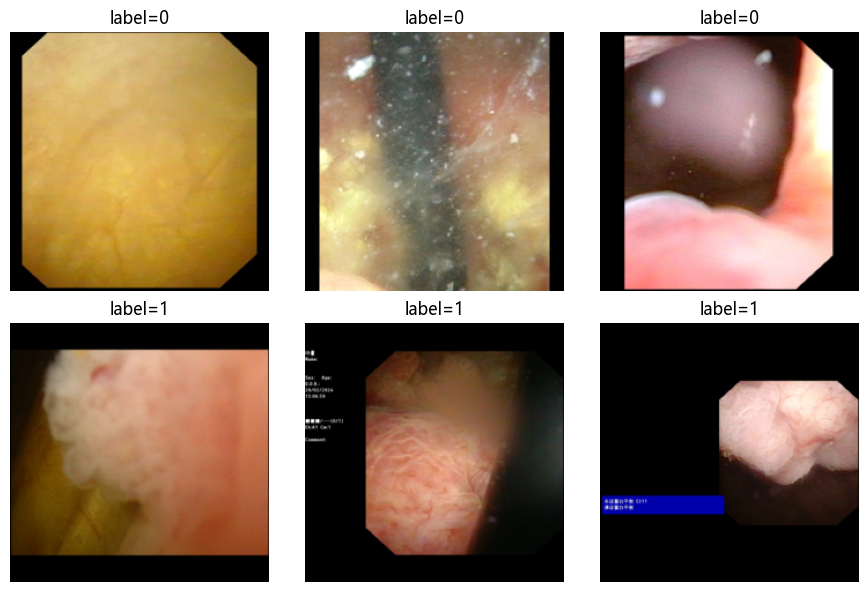

External Inference: 100%|██████████| 247/247 [15:19<00:00,  3.72s/it]


=== 外部验证集评估结果 ===
样本总数: 15793 (normal=14588, tumor=1205)
ACC:         0.9544
F1-score:    0.7020
AUC:         0.9465
Specificity: 0.9751
Sensitivity: 0.7037


In [20]:
# %% [markdown]
# ## 外部验证集评估 — 带去黑边 & 居中补齐预处理

# %%
import os
import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm
from PIL import Image, ImageOps
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, f1_score,
    roc_auc_score, confusion_matrix
)

# —— 新增：去黑边 + 居中补齐预处理函数 —— 
def preprocess_image(img: Image.Image) -> Image.Image:
    # 1) 转为 numpy 判断哪儿全黑
    arr = np.array(img)
    if arr.ndim == 3:
        mask = np.any(arr != arr[0,0,:], axis=2)
    else:
        mask = arr != arr[0,0]
    coords = np.argwhere(mask)
    if coords.size:
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0)
        img = img.crop((x0, y0, x1 + 1, y1 + 1))
    # 2) 居中 pad 成正方形
    w, h = img.size
    max_wh = max(w, h)
    pad_w = (max_wh - w) // 2
    pad_h = (max_wh - h) // 2
    padding = (pad_w, pad_h, max_wh - w - pad_w, max_wh - h - pad_h)
    img = ImageOps.expand(img, padding, fill=0)
    return img

# 1. 配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ext_root = r'D:\Leko\testset\testset1(8)'
best_model_path = os.path.join(Config.save_dir, "best_model.pth")
batch_size = 64
num_workers = 0

# 2. 预处理（加上 preprocess_image）
ext_transform = transforms.Compose([
    transforms.Lambda(lambda img: preprocess_image(img)),  # ← 新增
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406),
                         std=(0.229,0.224,0.225)),
])

# 3. 构建 DataLoader
ext_dataset = ImageFolder(root=ext_root, transform=ext_transform)
print("External classes:", ext_dataset.classes)
ext_loader = DataLoader(
    ext_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)
print(f"外部验证集: {len(ext_dataset)} 张图, {len(ext_loader)} 个 batch")

# 4. 初始化模型并加载权重
model = TumorClassifier(dropout_p=0.7).to(device)
state = torch.load(best_model_path, map_location=device)
model.load_state_dict(state)
model.eval()
print("✅ Loaded best_model.pth")
# %% [markdown]
# ## 外部验证集评估 — 展示每个 label 下 3 张经过 transform 的图像

# %%
import matplotlib.pyplot as plt
import random

# 先从 ext_dataset 里各抽 3 张
samples_per_class = {0: [], 1: []}
indices = list(range(len(ext_dataset)))
random.shuffle(indices)
for idx in indices:
    img, label = ext_dataset[idx]  # 已经做了 preprocess + Resize + ToTensor + Normalize
    if len(samples_per_class[label]) < 3:
        samples_per_class[label].append(img)
    if len(samples_per_class[0]) == 3 and len(samples_per_class[1]) == 3:
        break

# 定义一个反归一化，用于可视化
inv_norm = transforms.Normalize(
    mean=[-m/s for m,s in zip((0.485,0.456,0.406),(0.229,0.224,0.225))],
    std=[1/s for s in (0.229,0.224,0.225)]
)

# 绘图
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for cls, row in samples_per_class.items():
    for i, tensor_img in enumerate(row):
        img_vis = inv_norm(tensor_img)                 # 先反归一化
        img_vis = img_vis.permute(1,2,0).clamp(0,1)    # HWC
        axes[cls, i].imshow(img_vis.numpy())
        axes[cls, i].set_title(f"label={cls}")
        axes[cls, i].axis('off')
plt.tight_layout()
plt.show()

# 5. 推理
all_probs, all_labels = [], []
with torch.inference_mode():
    for imgs, labels in tqdm(ext_loader, desc="External Inference"):
        imgs = imgs.to(device, non_blocking=True)
        logits = model(imgs).view(-1)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.numpy())

all_probs  = np.array(all_probs)
all_labels = np.array(all_labels).astype(int)

# 6. 计算并打印指标
preds = (all_probs >= 0.5).astype(int)
acc  = accuracy_score(all_labels, preds)
f1   = f1_score(all_labels, preds)
auc  = roc_auc_score(all_labels, all_probs)
tn, fp, fn, tp = confusion_matrix(all_labels, preds).ravel()
spec = tn / (tn + fp)
sens = tp / (tp + fn)

print("\n=== 外部验证集评估结果 ===")
print(f"样本总数: {len(ext_dataset)} "
      f"(normal={ext_dataset.targets.count(0)}, tumor={ext_dataset.targets.count(1)})")
print(f"ACC:         {acc:.4f}")
print(f"F1-score:    {f1:.4f}")
print(f"AUC:         {auc:.4f}")
print(f"Specificity: {spec:.4f}")
print(f"Sensitivity: {sens:.4f}")
